In [28]:
import os
import ast
import re
import openai
import time
import json
import gzip
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from urllib.request import urlopen
from dotenv import load_dotenv,find_dotenv
import pinecone
load_dotenv(find_dotenv("my_env.env"))

True

In [29]:
# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [30]:
df = pd.read_csv("scores (1).csv")

# 2. Import and apply embeddings from HuggingFace

In [31]:
from langchain.embeddings import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings()

# Embed email content
df['embeddings'] = df.apply(lambda row: embeddings.embed_query(row['textdata']), axis=1)

### Initialize Pinecone and upload the vector to pinecone

In [32]:
import pinecone
from langchain.vectorstores import Pinecone

pinecone.init(
    api_key=os.getenv('PINECONE_API_KEY'),  
    environment=os.getenv('PINECONE_ENV')  
)

In [33]:
texts =df['textdata'].tolist()
texts

['Spare bis zu 695€! BACK TO SCHOOL mit bestem Schlaf durch unsere Schlafprodukte! Ob Studentenbude, Kinderzimmer oder sonst ein Schlafzimmer - Jeder sollte erholt schlafen, um maximale Leistung zu erbringen. Deshalb gibt es bei uns pünktlich zum Schul- und Semesterstart bis zu 40% Rabatt! So kann jeder mit voller Kraft in den Tag starten! Jetzt sparen! Alle Rabatte sind direkt auf unserer Website ersichtlich und nicht mit anderen Rabattaktionen kombinierbar. 100 Nächte Probeschlafen Kostenlose Lieferung und Abholung 10 Jahre Garantie Emma Matratzen GmbH Wilhelm-Leuschner-Str. 78 60329 Frankfurt Am Main Website | Impressum | Unsubscribe ID number: 04522940020 | Tax ID: DE301904406',
 'Die Emma Black Weeks sind da: Spare bis zu 50%! Black Weeks bei Emma: Jetzt einkaufen und sparen! Die pure Freude mit bis zu 50% Rabatt. Sichere Dir ab heute Dein Black Weeks Angebot! Entdecke Schlafprodukte zu entspannten Preisen – und schlummere sanft, während andere nachts wach liegen. Spare jetzt weit

### Create indexes in pinecone, before upload vectors in pinecone

In [34]:
# Create a single Pinecone index to store all embeddings
vstore = Pinecone.from_texts(texts, embeddings, index_name='vectors')

In [35]:
# Check the stats of vectors, such as dimensions and count (cosine similarity configured)
index = pinecone.Index("vectors")
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

### Elbow Method

In [36]:
from sklearn.cluster import KMeans

In [37]:
# Get the embeddings as a NumPy array
embeddings_array = np.vstack(df['embeddings'])

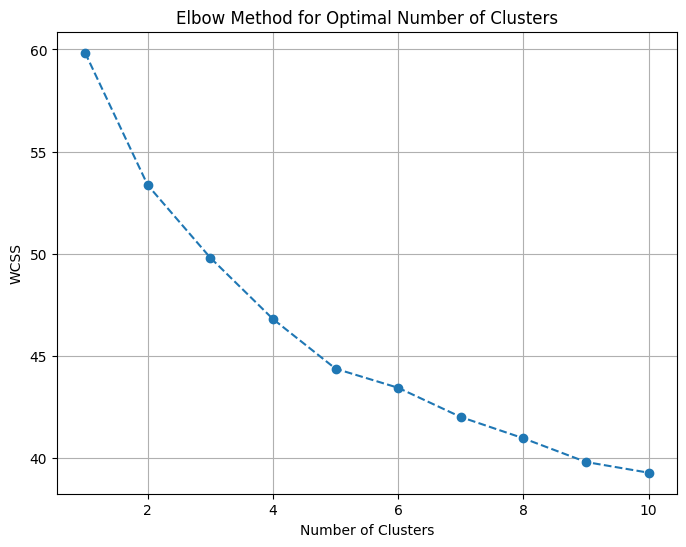

In [38]:
# Determine the optimal number of clusters using the elbow method
wcss = []

# Try a range of cluster numbers, for example, from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(embeddings_array)
    wcss.append(kmeans.inertia_)

# Plot the within-cluster sum of squares (WCSS) for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

### K-means Clustering

In [39]:
# Assuming you want to cluster into, let's say, 5 clusters
num_clusters = 5

In [40]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_array)
# Now, you have a 'cluster' column in your DataFrame with cluster assignments

C:\Users\xiang\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### K-means Clustering Visualization

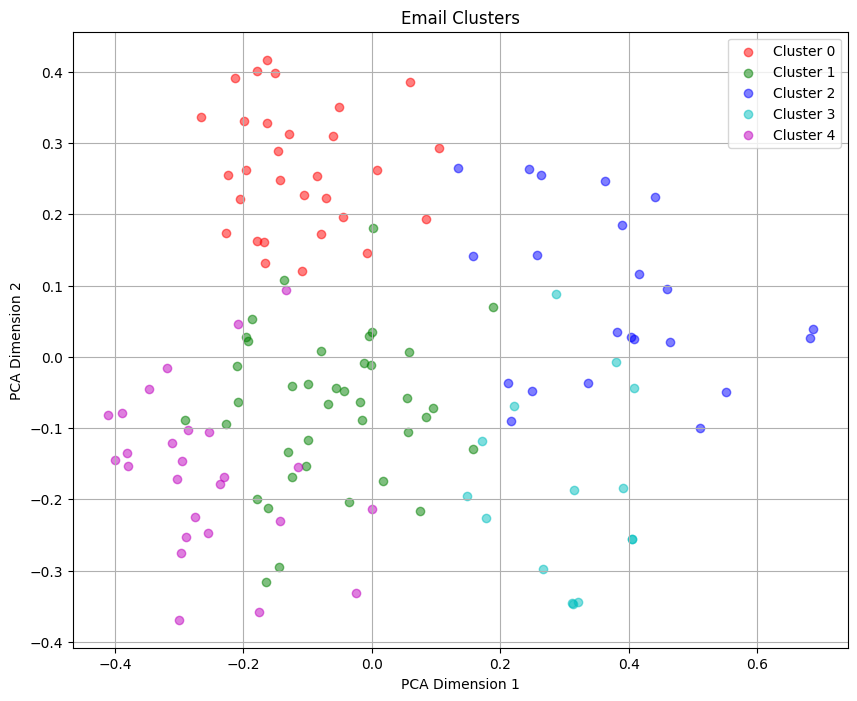

In [41]:
from sklearn.decomposition import PCA

# Perform PCA for visualization (reduce embeddings to 2D)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_array)

# Add the 2D embeddings to the DataFrame
df['embedding_x'] = embeddings_2d[:, 0]
df['embedding_y'] = embeddings_2d[:, 1]

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 8))

# Define colors for each cluster (adjust as needed)
colors = ['r', 'g', 'b', 'c', 'm']  # Include colors for 10 clusters

for cluster_id in range(num_clusters):
    cluster_df = df[df['cluster'] == cluster_id]
    plt.scatter(
        cluster_df['embedding_x'],
        cluster_df['embedding_y'],
        label=f'Cluster {cluster_id}',
        color=colors[cluster_id],
        alpha=0.5
    )

plt.title('Email Clusters')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid()
plt.show()

### create new csv file with clusters

In [53]:
# Print cluster assignments for each email
print(df[['campaign_title', 'cluster']])

# Optionally, you can save the DataFrame with cluster assignments to a new CSV file
df.to_csv('clustered_emails2.csv', index=False)

# To view the email contents in each cluster, you can iterate through the clusters
for cluster_id in range(num_clusters):
    cluster_df = df[df['cluster'] == cluster_id]
    print(f'Cluster {cluster_id}:')
    for index, row in cluster_df.iterrows():
        print(f'Email Title: {row["campaign_title"]}')
        print(f'Email Content: {row["textdata"]}')

                                    campaign_title  cluster
0                 at_back_to_school_sale_2021sept8        1
1                       at_bf_broadcast1_2022oct28        4
2                       at_bf_broadcast4_2022nov17        4
3                       at_bf_broadcast7_2022nov10        4
4                        at_bf_broadcast_2022nov07        4
..                                             ...      ...
127  ch_blackfridaysale_newsletter4_2021november27        4
128  ch_blackfridaysale_newsletter5_2021november29        4
129          ch_black_weeks_private_sale_2021nov03        4
130                 ch_carnivalsale23_#1_2023feb16        0
131               ch_christmasemail_2021december24        3

[132 rows x 2 columns]
Cluster 0:
Email Title: at_broadcast_2022dec20
Email Content: Die besten Materialien für eine erholsame Nacht Was macht unsere Emma Produkte so hochwertig? Was macht unsere Emma Produkte so hochwertig? Vielleicht bist du auch schon über das Gerücht gestolp

### mean, median, min, max, standard deviation

In [42]:
import numpy as np

# Get unique clusters in your DataFrame
unique_clusters = df['cluster'].unique()

# Iterate through each cluster and calculate/display statistics
for cluster in unique_clusters:
    cluster_data = df[df['cluster'] == cluster]['target']
    
    print(f"Cluster {cluster} Statistics:")
    print("Mean:", round(np.mean(cluster_data), 3))
    print("Median:", round(np.median(cluster_data), 3))
    print("Min:", round(np.min(cluster_data), 3))
    print("Max:", round(np.max(cluster_data), 3))
    print("Standard Deviation:", round(np.std(cluster_data), 3))
    print("\n")

Cluster 1 Statistics:
Mean: 0.121
Median: 0.098
Min: 0.056
Max: 0.286
Standard Deviation: 0.06


Cluster 4 Statistics:
Mean: 0.155
Median: 0.149
Min: 0.087
Max: 0.262
Standard Deviation: 0.045


Cluster 0 Statistics:
Mean: 0.09
Median: 0.084
Min: 0.043
Max: 0.178
Standard Deviation: 0.028


Cluster 2 Statistics:
Mean: 0.073
Median: 0.067
Min: 0.036
Max: 0.148
Standard Deviation: 0.026


Cluster 3 Statistics:
Mean: 0.266
Median: 0.202
Min: 0.062
Max: 0.699
Standard Deviation: 0.189




### visualize click rates for each clusters

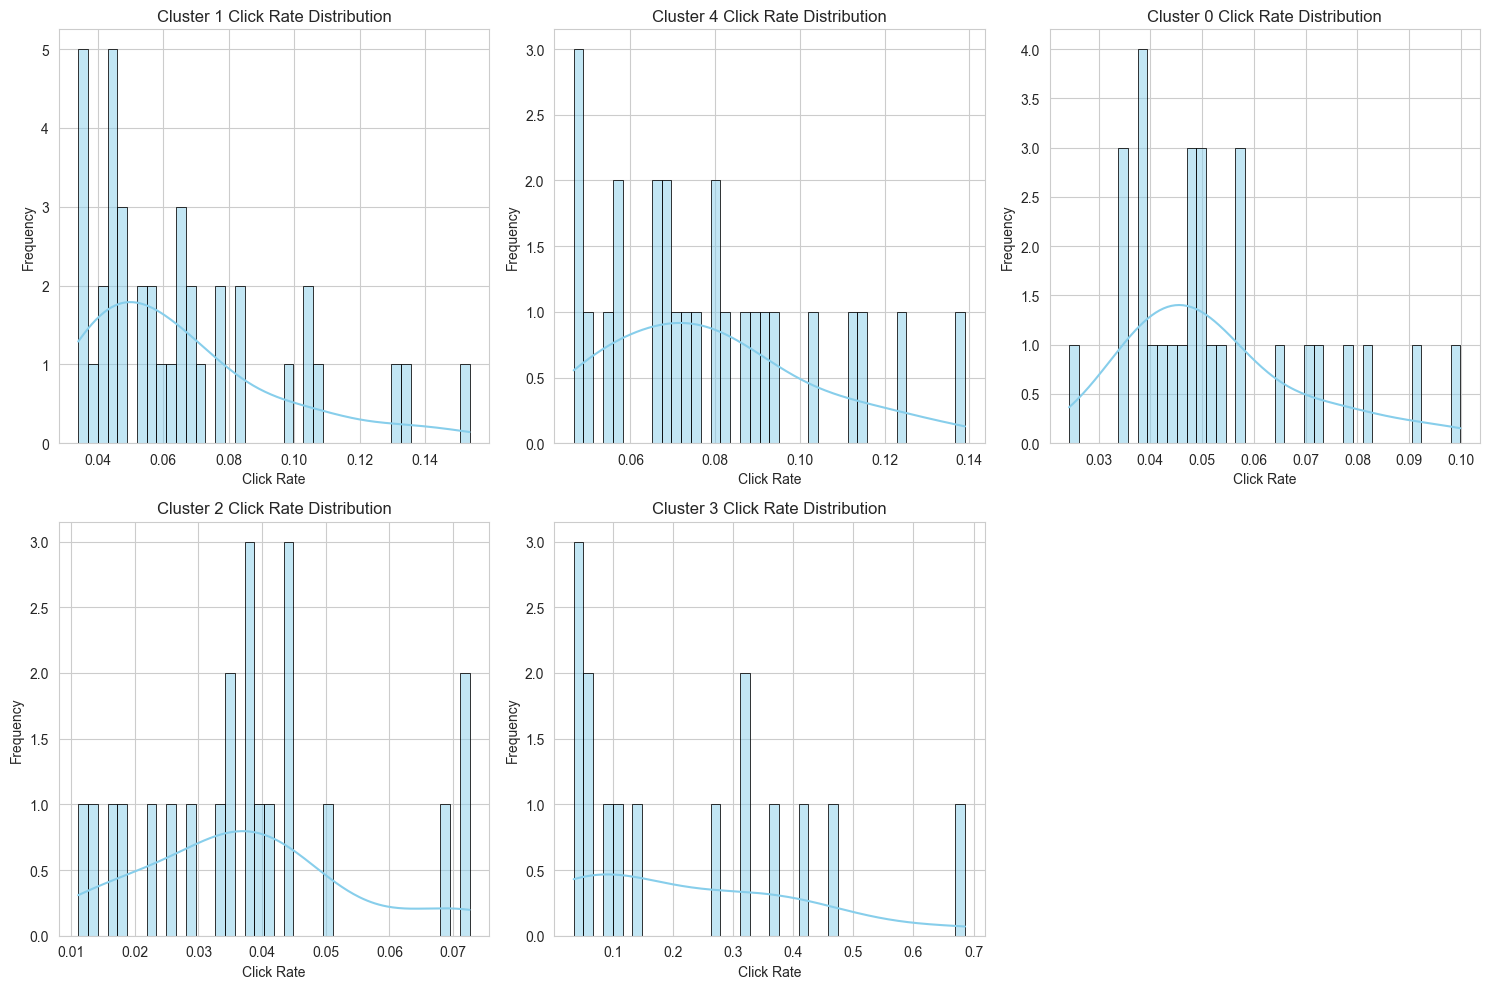

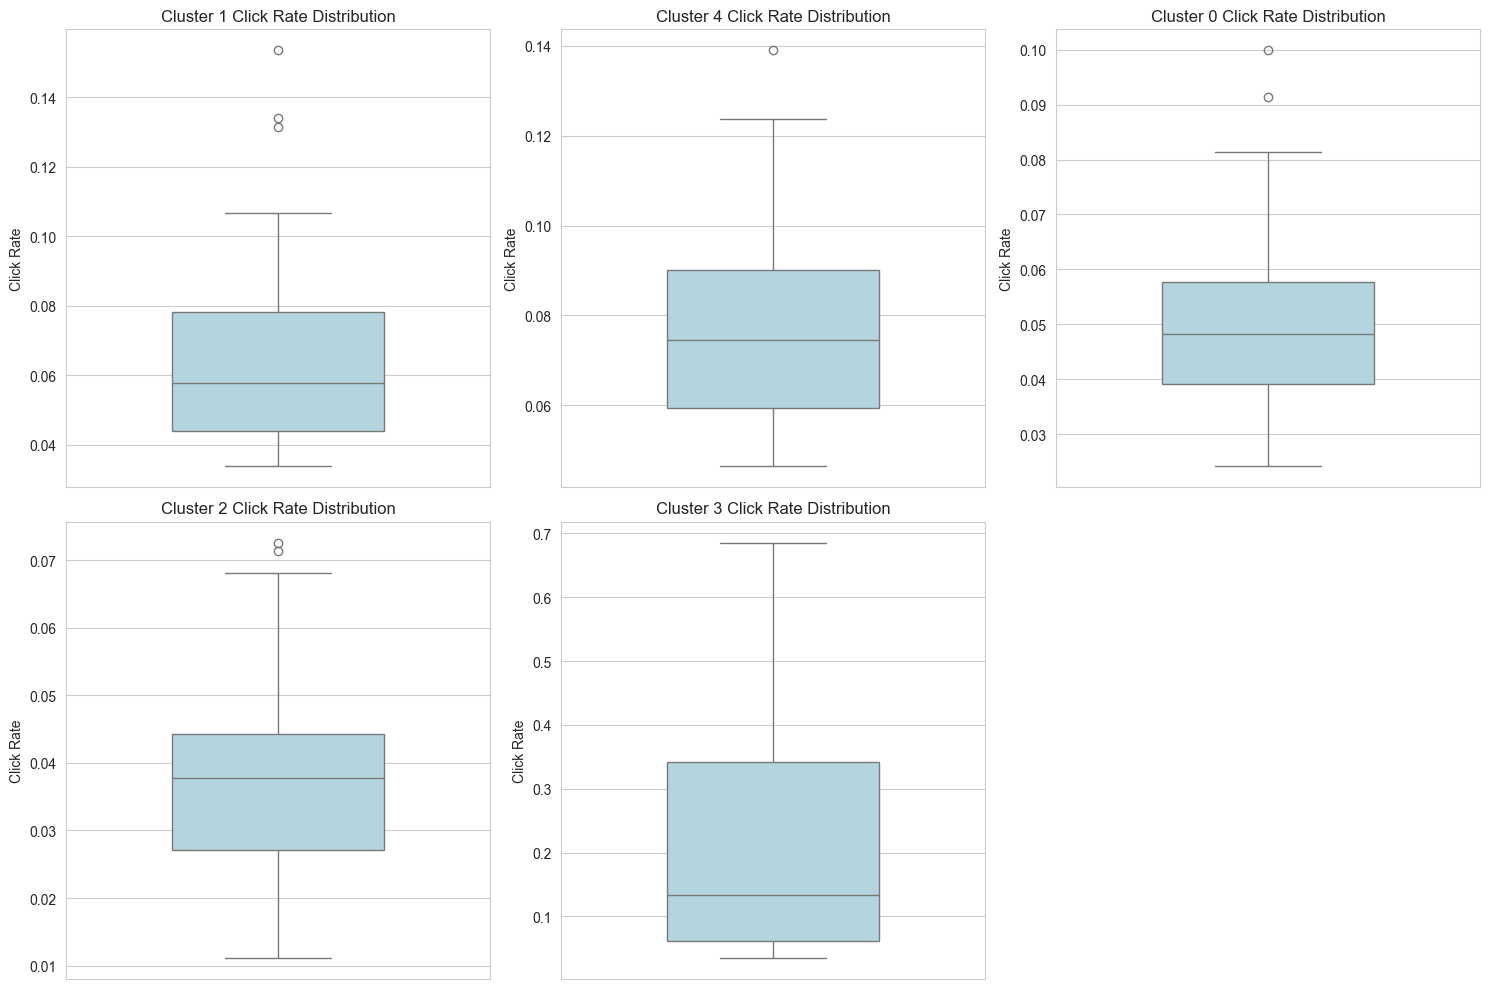

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set_style('whitegrid')

# Get the unique clusters from your DataFrame
unique_clusters = df['cluster'].unique()
num_clusters = len(unique_clusters)

# Determine the number of rows and columns for subplots based on the number of clusters
num_rows = (num_clusters // 3) + (1 if num_clusters % 3 != 0 else 0)
num_cols = min(num_clusters, 3)

# Create histograms for click rate distribution in each cluster
plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size

# Create subplots for each cluster
for i, cluster in enumerate(unique_clusters):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df[df['cluster'] == cluster]['clickrate'], bins=40, kde=True, color='skyblue', edgecolor='black')
    plt.xlabel('Click Rate')
    plt.ylabel('Frequency')
    plt.title(f'Cluster {cluster} Click Rate Distribution')

plt.tight_layout()  # Ensure subplots do not overlap
plt.show()

# Create box plots for click rate distribution in each cluster
plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size

# Create subplots for each cluster
for i, cluster in enumerate(unique_clusters):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df[df['cluster'] == cluster]['clickrate'], color='lightblue', width=0.5)
    plt.ylabel('Click Rate')
    plt.title(f'Cluster {cluster} Click Rate Distribution')

plt.tight_layout()  # Ensure subplots do not overlap
plt.show()

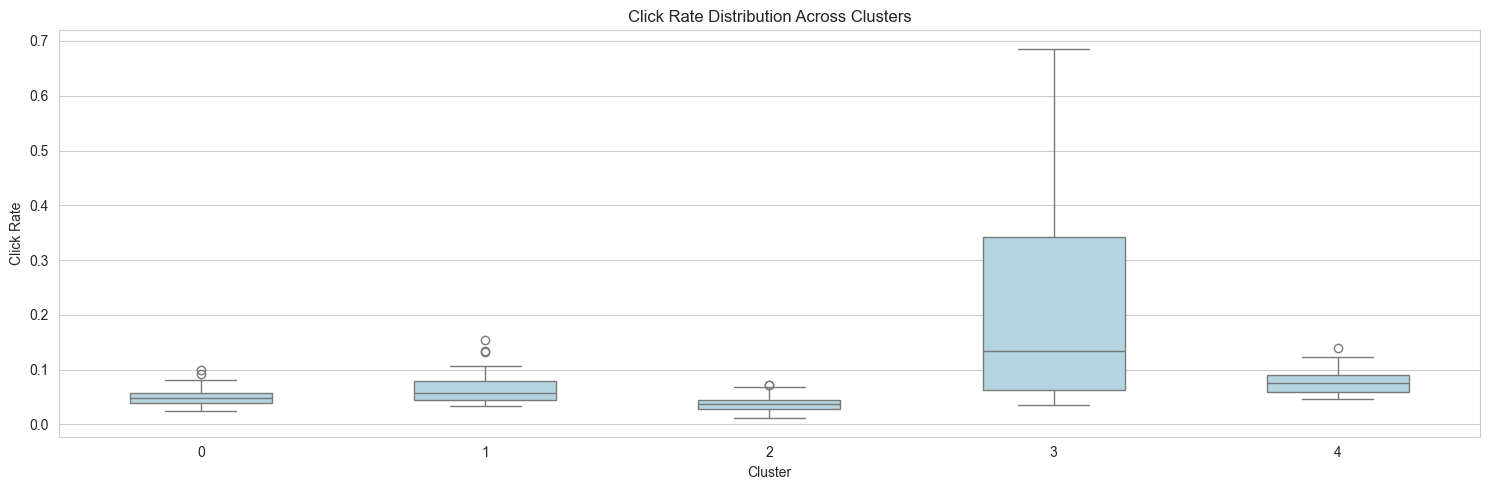

In [46]:
# Set the style for seaborn
sns.set_style('whitegrid')

# Get the unique clusters from your DataFrame
unique_clusters = df['cluster'].unique()

# Create histograms for click rate distribution in each cluster
plt.figure(figsize=(15, 5))  # Adjust the figure size

# Create a box plot showing the click rate distribution for all clusters
sns.boxplot(x='cluster', y='clickrate', data=df, color='lightblue', width=0.5)
plt.xlabel('Cluster')
plt.ylabel('Click Rate')
plt.title('Click Rate Distribution Across Clusters')

plt.tight_layout()  # Ensure subplots do not overlap
plt.show()

### heatmap for each clusters

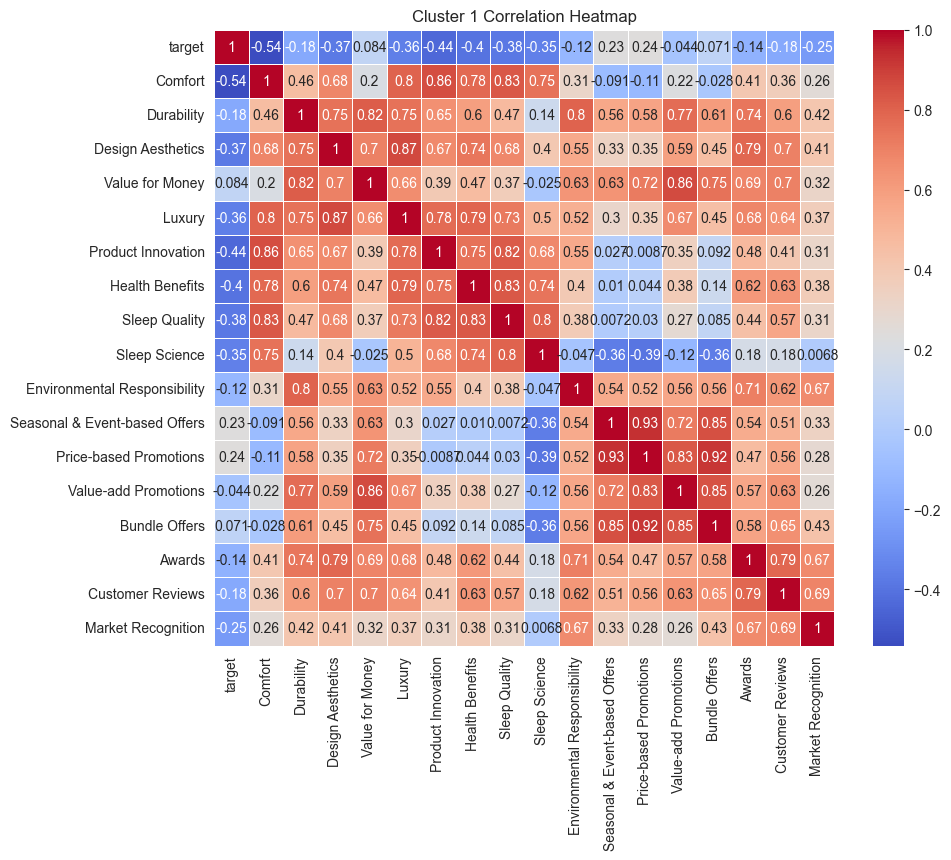

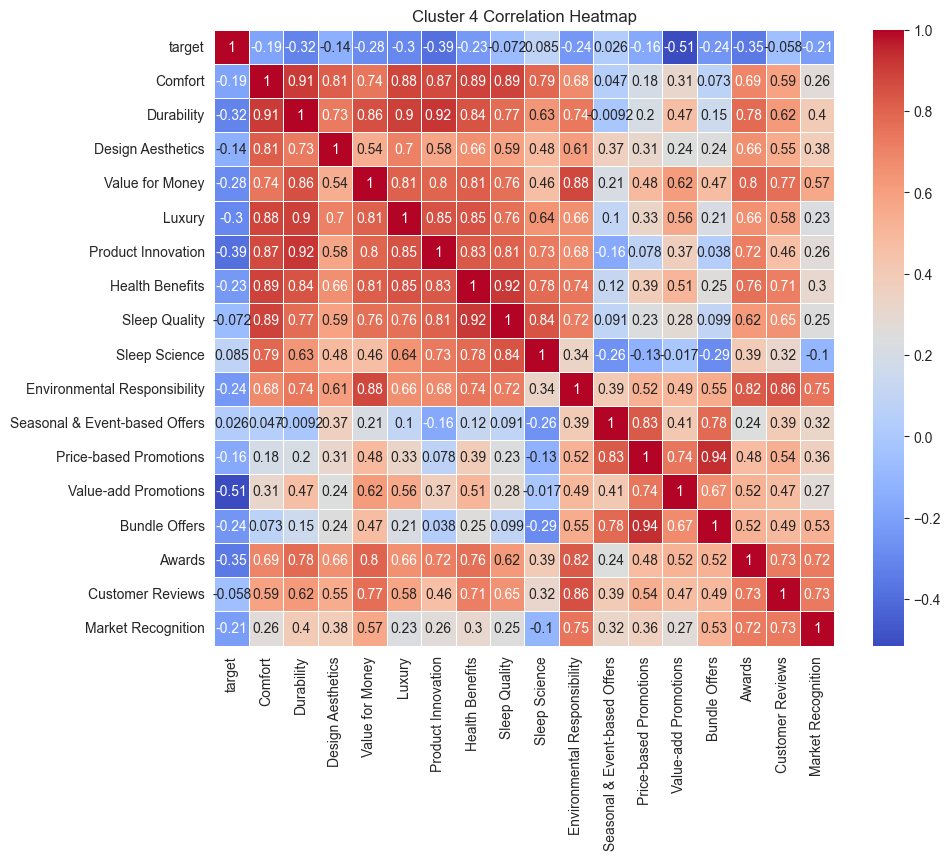

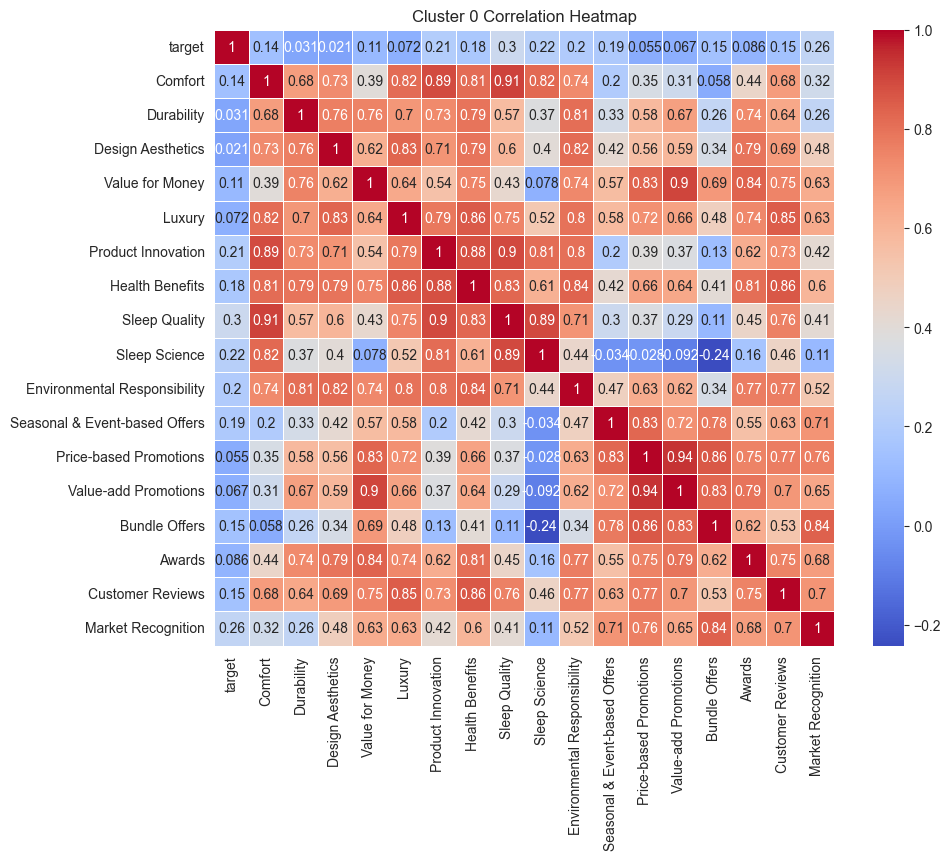

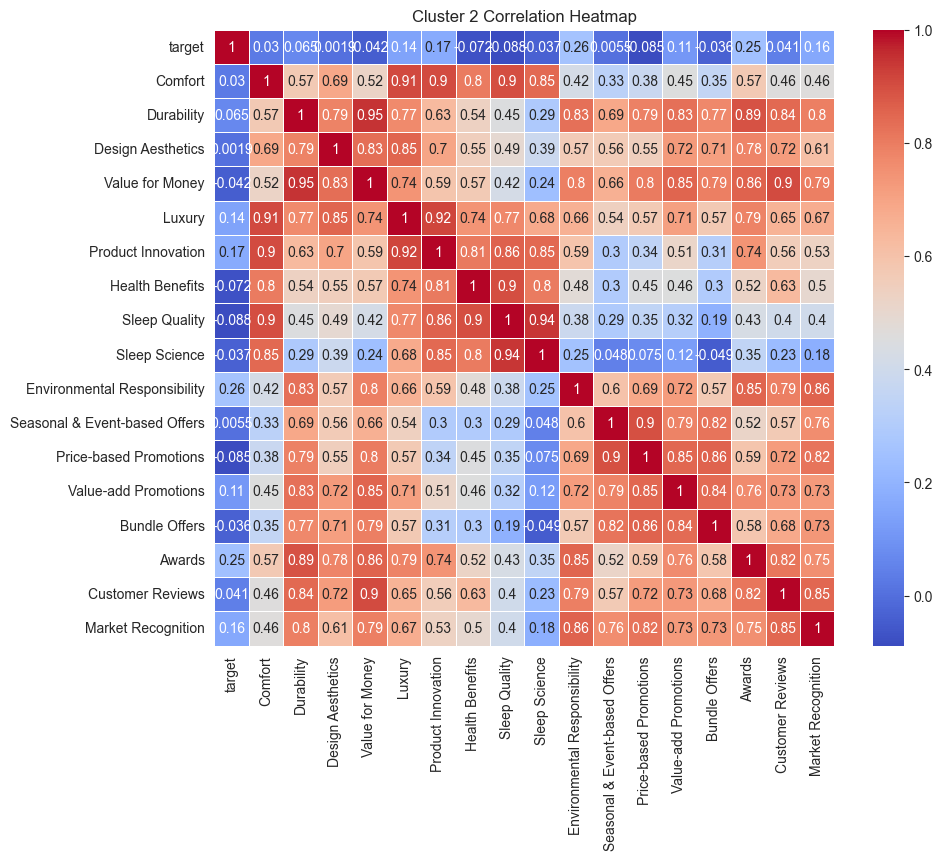

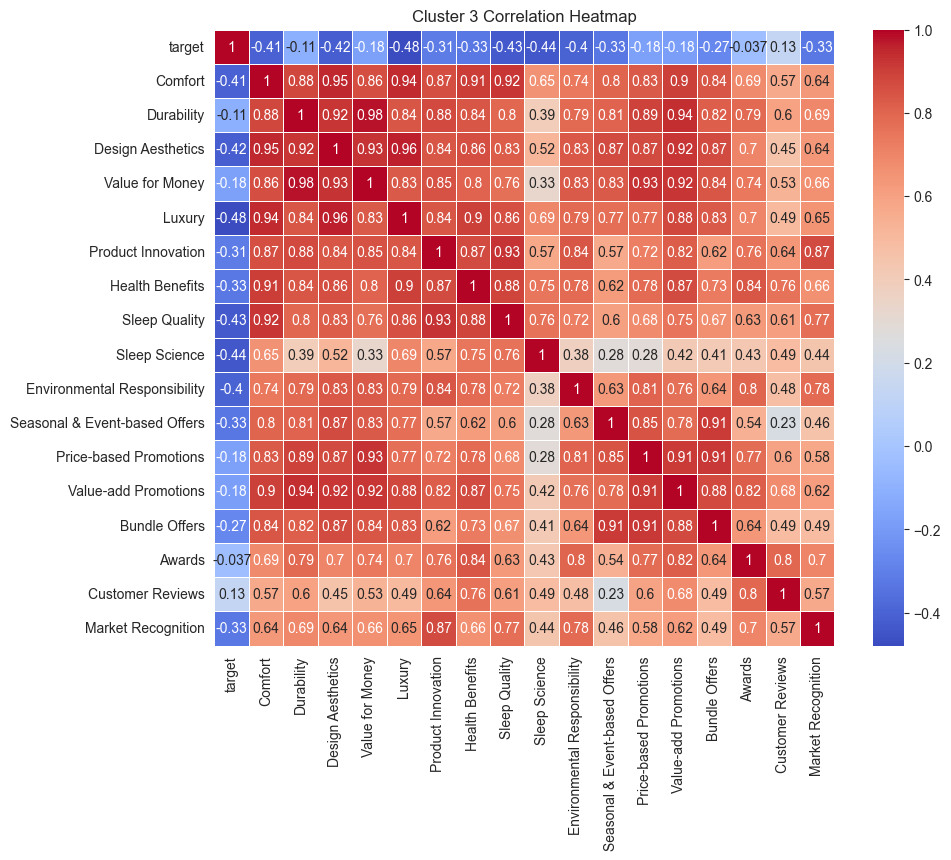

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset from Excel (assuming you already have the data loaded in 'clustered_emails2.csv')
clustered_emails2 = pd.read_csv('clustered_emails2.csv')

# Define your feature names
feature_names = [
    'Comfort', 'Durability', 'Design Aesthetics', 'Value for Money', 'Luxury',
    'Product Innovation', 'Health Benefits', 'Sleep Quality', 'Sleep Science',
    'Environmental Responsibility', 'Seasonal & Event-based Offers',
    'Price-based Promotions', 'Value-add Promotions', 'Bundle Offers',
    'Awards', 'Customer Reviews', 'Market Recognition'
]

# Iterate through each cluster and create a heatmap
for cluster in clustered_emails2['cluster'].unique():
    # Select the rows for the current cluster
    cluster_data = clustered_emails2[clustered_emails2['cluster'] == cluster]
    
    # Select the columns you want to include in the correlation analysis
    # Include the "target" variable and your feature columns using the defined feature names
    selected_columns = cluster_data[['target'] + feature_names]
    
    # Calculate the correlation matrix for the current cluster
    correlation_matrix = selected_columns.corr()
    
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    
    # Create a heatmap using Seaborn for the current cluster
    sns.heatmap(
        correlation_matrix,
        annot=True,  # Show the correlation values on the heatmap
        cmap='coolwarm',  # Choose a color map
        linewidths=.5,  # Add lines between cells
    )
    
    # Set plot title for the current cluster
    plt.title(f'Cluster {cluster} Correlation Heatmap')
    
    # Display the heatmap for the current cluster
    plt.show()

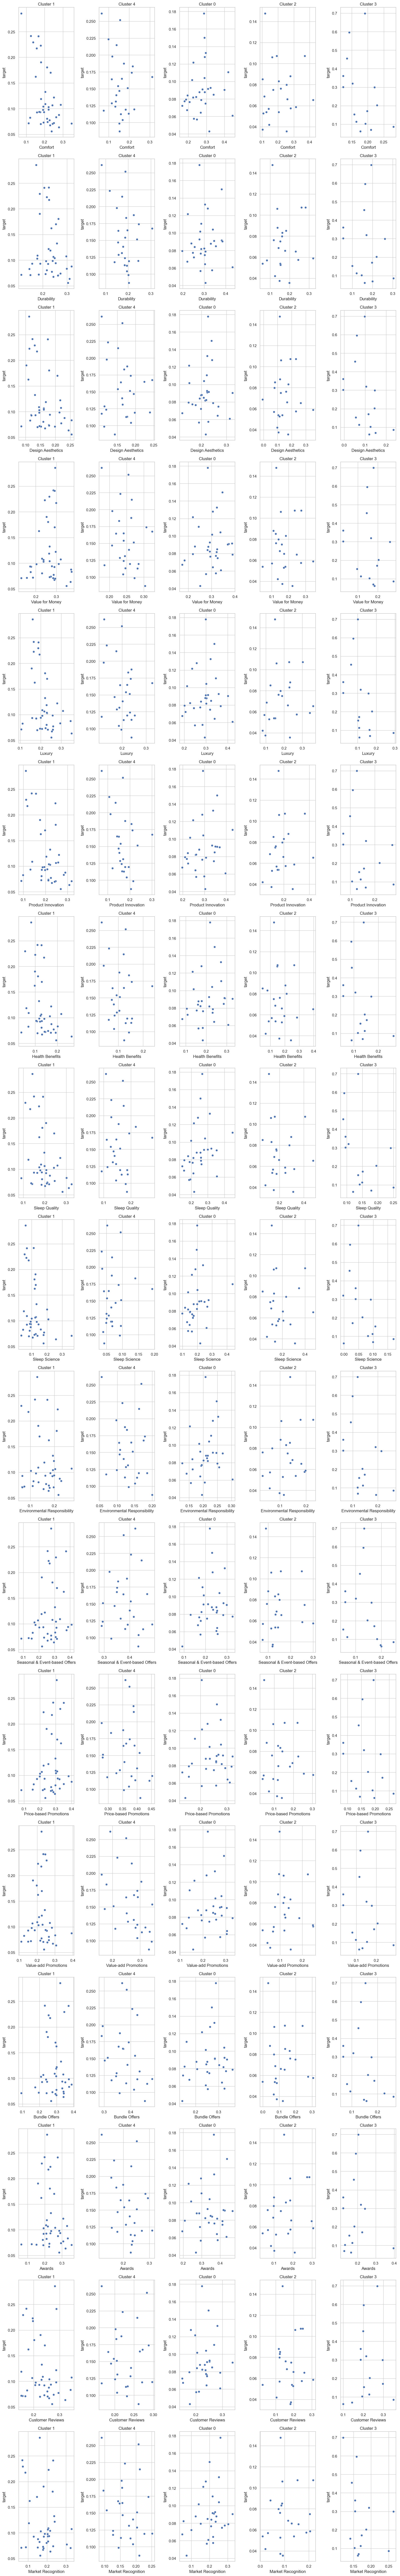

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define your feature names
feature_names = [
    'Comfort', 'Durability', 'Design Aesthetics', 'Value for Money', 'Luxury',
    'Product Innovation', 'Health Benefits', 'Sleep Quality', 'Sleep Science',
    'Environmental Responsibility', 'Seasonal & Event-based Offers',
    'Price-based Promotions', 'Value-add Promotions', 'Bundle Offers',
    'Awards', 'Customer Reviews', 'Market Recognition'
]

# Set the style for the scatter plots
sns.set(style="whitegrid")

# Get unique clusters in your DataFrame
unique_clusters = df['cluster'].unique()

# Create subplots for each feature and cluster
fig, axes = plt.subplots(nrows=len(feature_names), ncols=len(unique_clusters), figsize=(16, 6 * len(feature_names)))

# Iterate through feature names and clusters and plot scatter plots
for i, feature in enumerate(feature_names):
    for j, cluster in enumerate(unique_clusters):
        ax = axes[i, j]
        cluster_data = df[df['cluster'] == cluster]
        sns.scatterplot(data=cluster_data, x=feature, y='target', ax=ax)
        ax.set_xlabel(feature)
        ax.set_ylabel('target')
        ax.set_title(f'Cluster {cluster}')
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the scatter plots
plt.show()


### mean, median, max, min, and standard deviation for each dimension for each cluster, output an excel

In [48]:
import pandas as pd
import numpy as np

# Define your feature names
feature_names = [
    'Comfort', 'Durability', 'Design Aesthetics', 'Value for Money', 'Luxury',
    'Product Innovation', 'Health Benefits', 'Sleep Quality', 'Sleep Science',
    'Environmental Responsibility', 'Seasonal & Event-based Offers',
    'Price-based Promotions', 'Value-add Promotions', 'Bundle Offers',
    'Awards', 'Customer Reviews', 'Market Recognition'
]

# Get unique clusters in your DataFrame
unique_clusters = df['cluster'].unique()

# Create a list to collect statistics for each cluster
statistics_list = []

# Iterate through clusters and calculate statistics
for cluster in unique_clusters:
    cluster_data = df[df['cluster'] == cluster]
    statistics = {
        'Cluster': cluster,
    }
    
    for feature in feature_names:
        statistics[f'Mean_for_{feature}'] = np.mean(cluster_data[feature])
        statistics[f'Median_for_{feature}'] = np.median(cluster_data[feature])
        statistics[f'Max_for_{feature}'] = np.max(cluster_data[feature])
        statistics[f'Min_for_{feature}'] = np.min(cluster_data[feature])
        statistics[f'Std Deviation_for_{feature}'] = np.std(cluster_data[feature])
    
    # Append the statistics for this cluster to the list
    statistics_list.append(statistics)

# Create a DataFrame from the list of statistics
statistics_df = pd.DataFrame(statistics_list)

# Save the statistics to an Excel file
statistics_df.to_excel('cluster_statistics.xlsx', index=False)

### visualize and compare the mean, median, max, min, and standard deviation for each dimension for each cluster

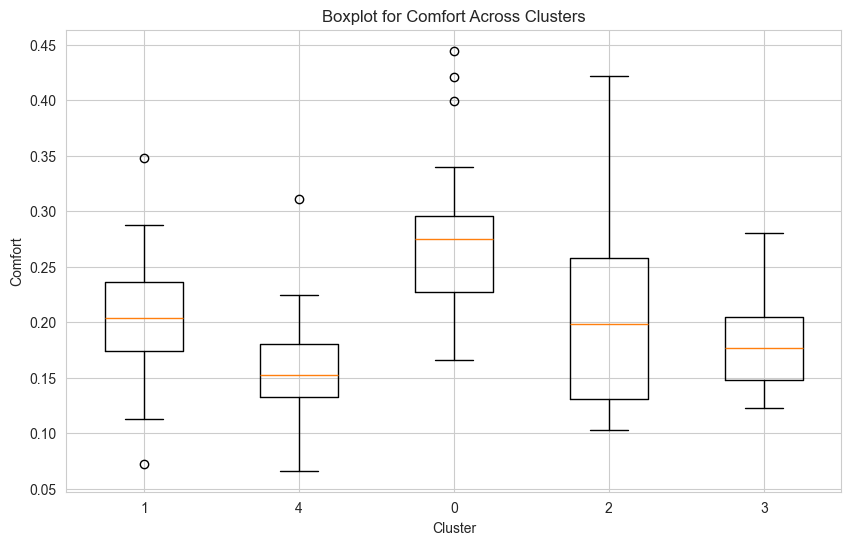

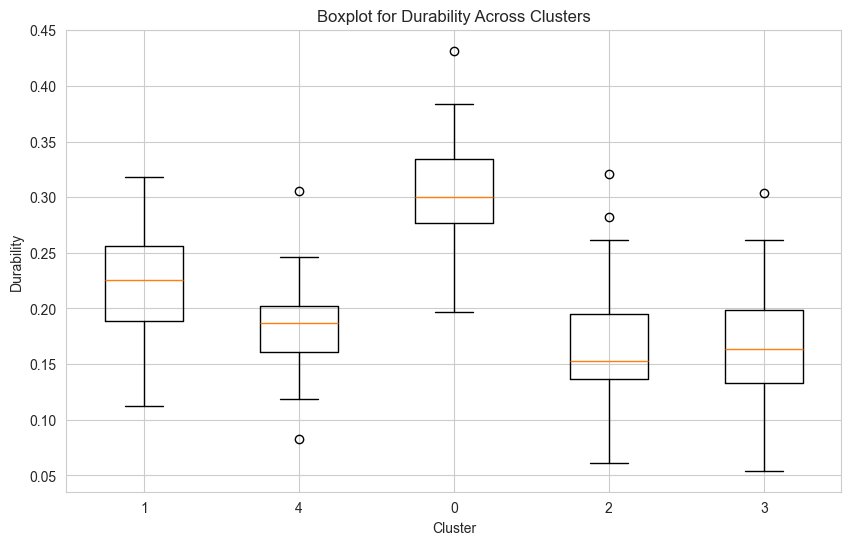

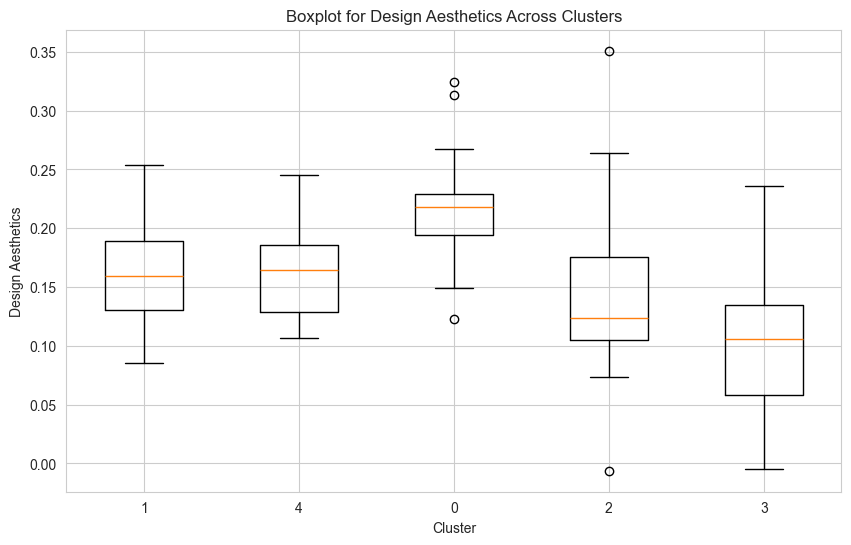

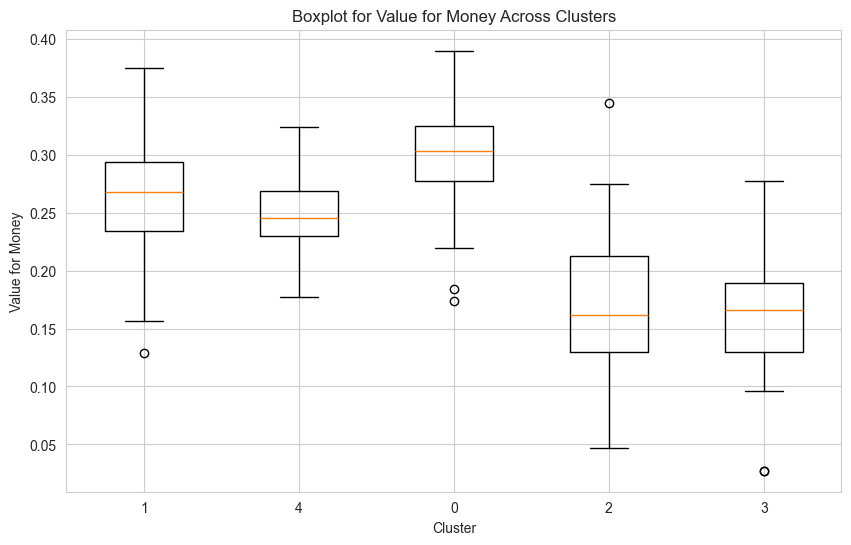

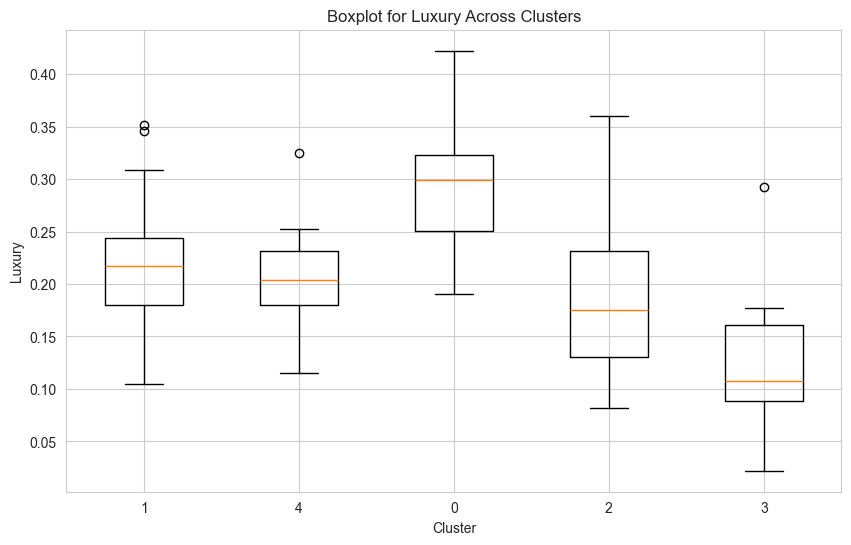

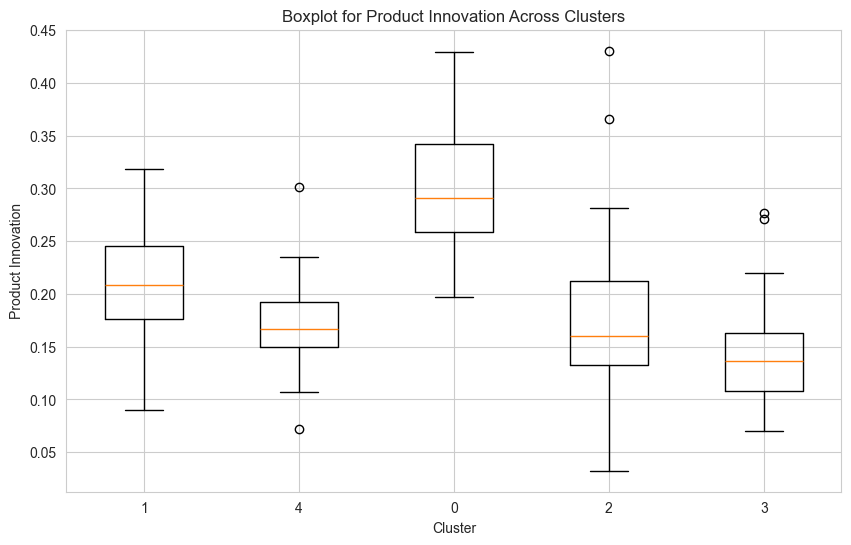

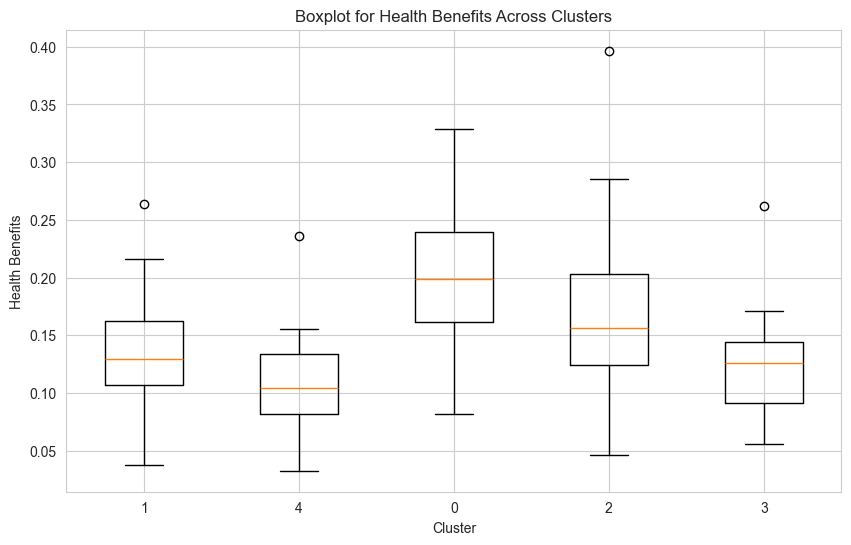

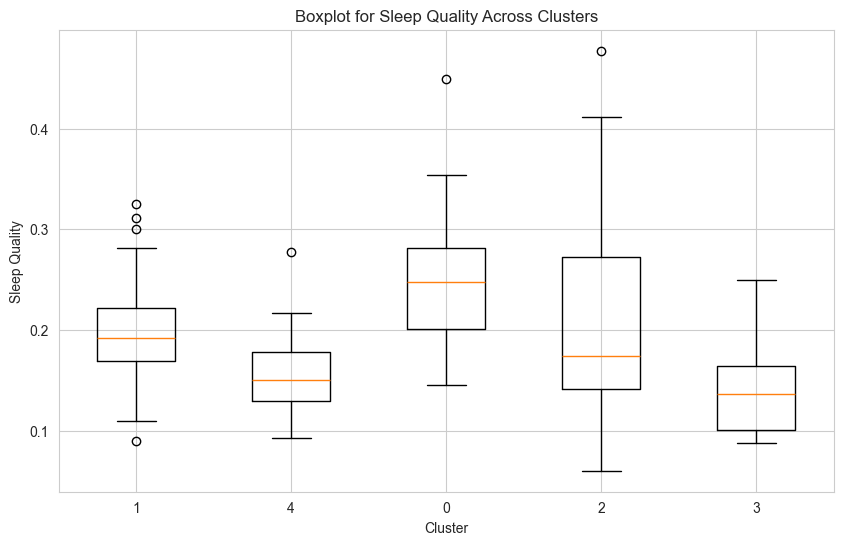

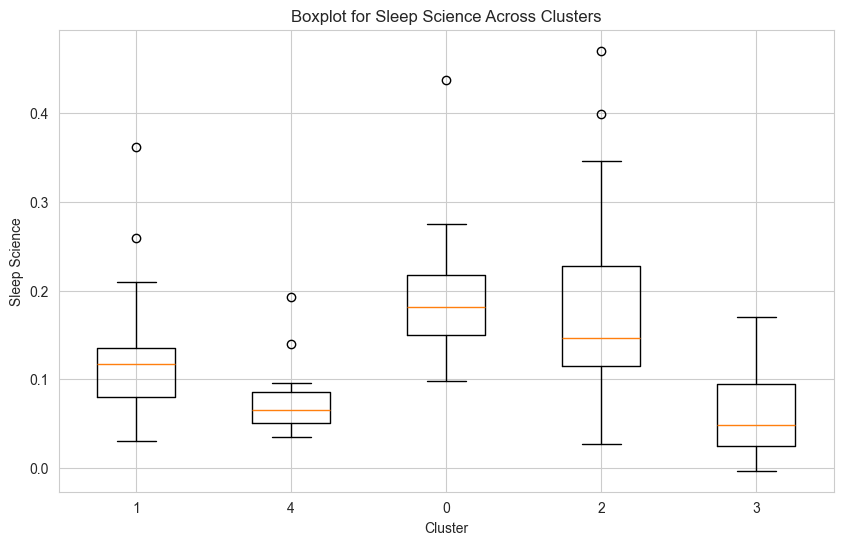

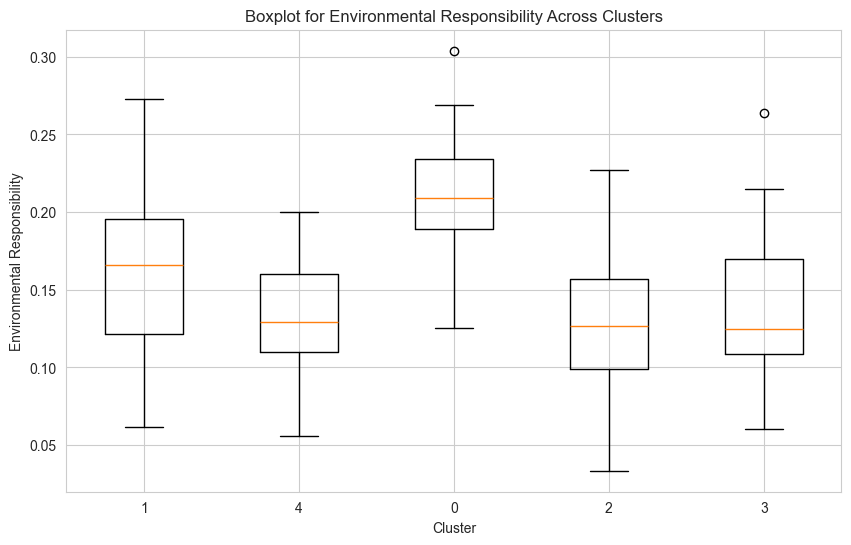

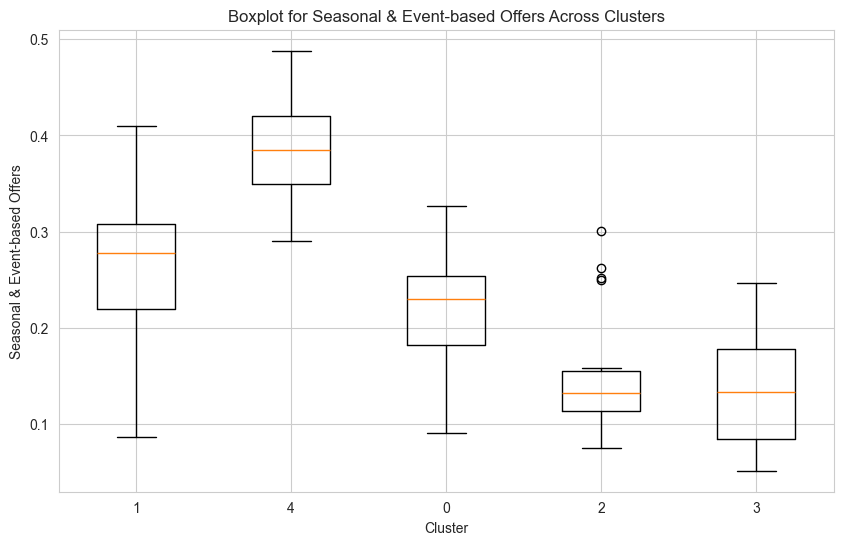

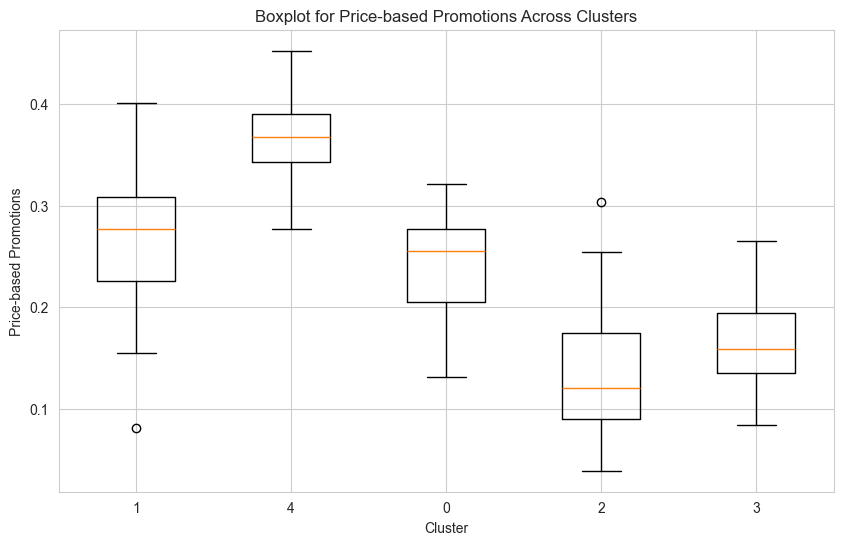

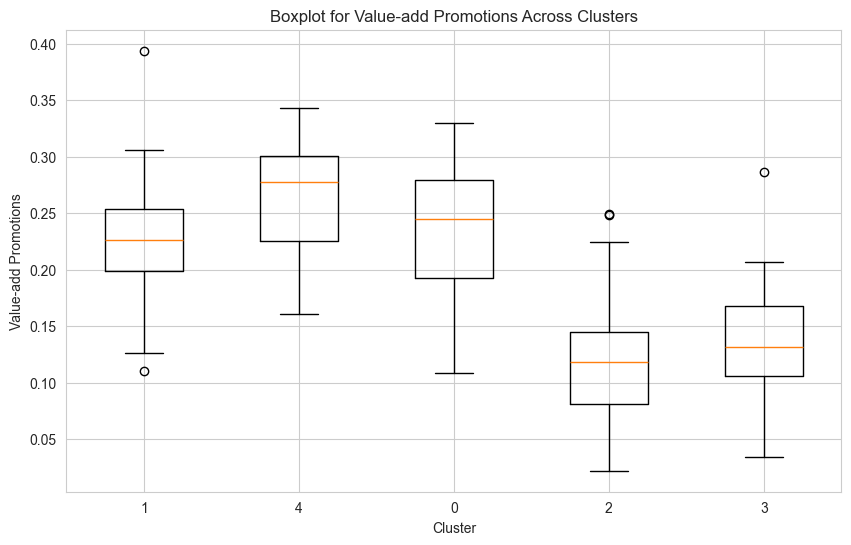

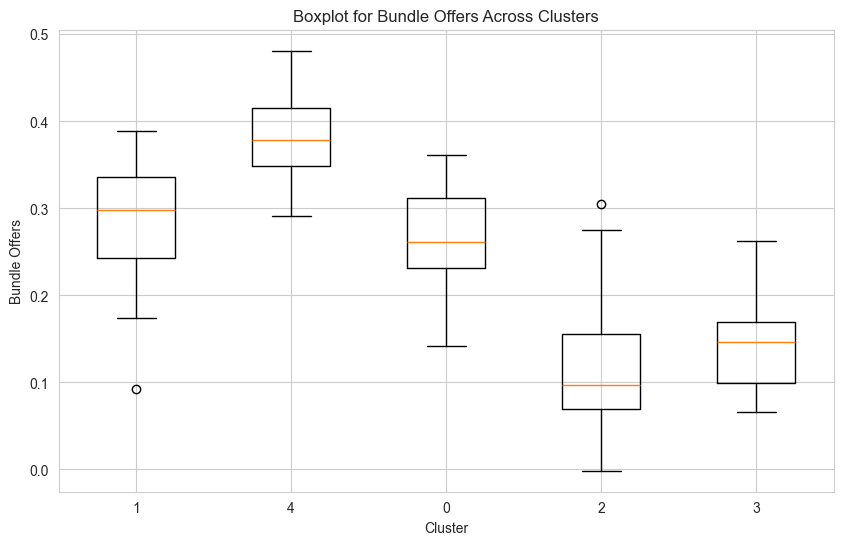

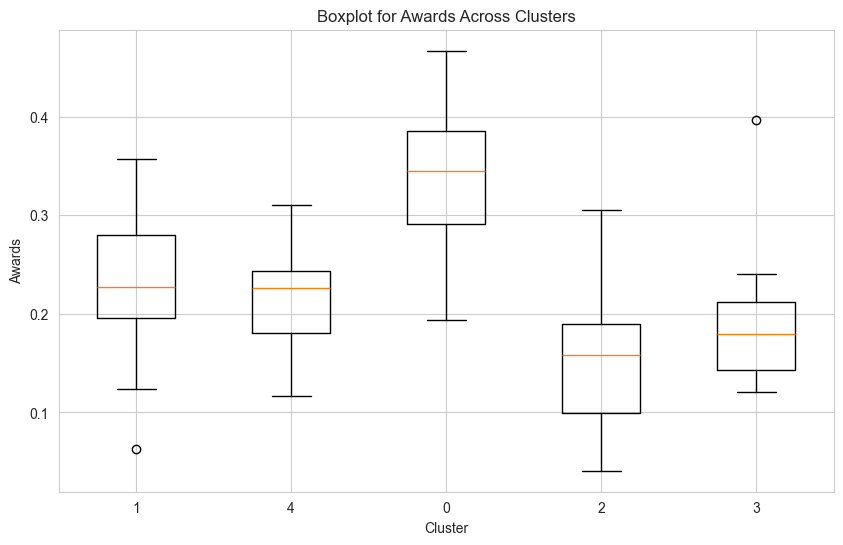

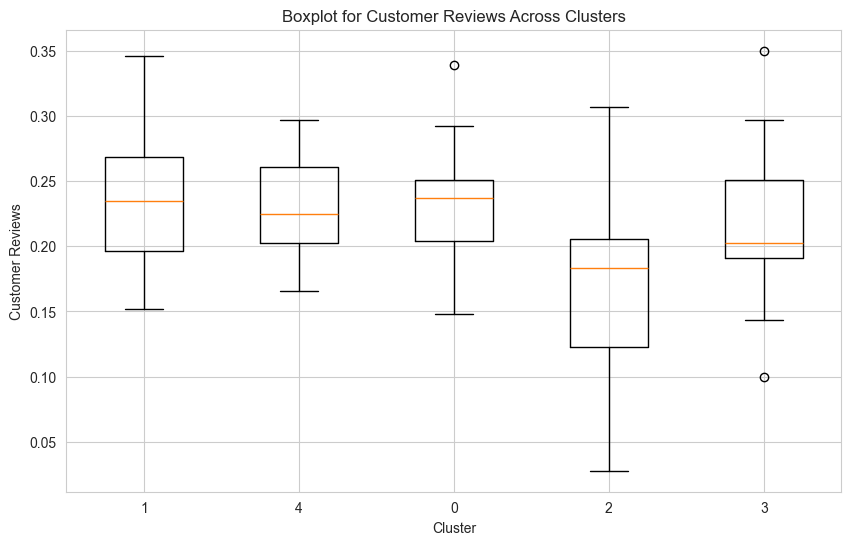

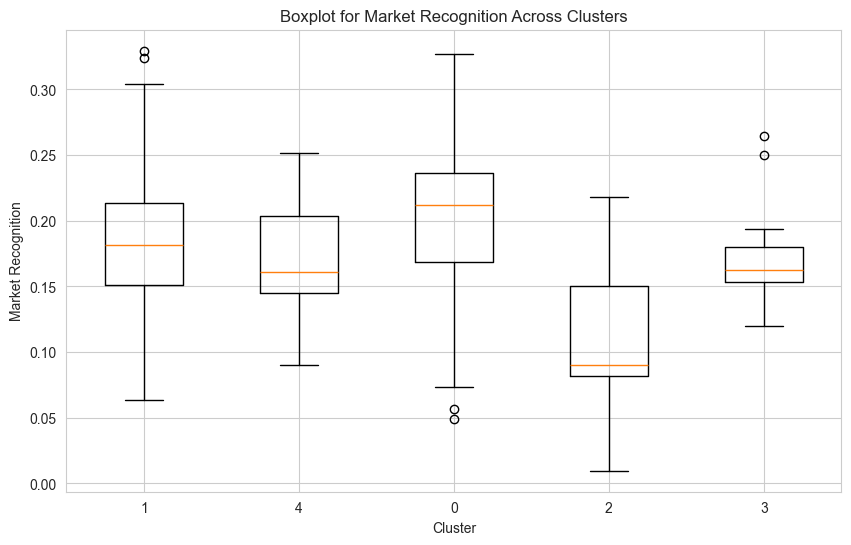

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define your feature names
feature_names = [
    'Comfort', 'Durability', 'Design Aesthetics', 'Value for Money', 'Luxury',
    'Product Innovation', 'Health Benefits', 'Sleep Quality', 'Sleep Science',
    'Environmental Responsibility', 'Seasonal & Event-based Offers',
    'Price-based Promotions', 'Value-add Promotions', 'Bundle Offers',
    'Awards', 'Customer Reviews', 'Market Recognition'
]

# Get unique clusters in your DataFrame
unique_clusters = df['cluster'].unique()

# Iterate through feature names and create separate boxplots
for feature in feature_names:
    plt.figure(figsize=(10, 6))
    
    # Create a list to store the data for each cluster
    data_for_boxplot = []
    
    # Iterate through clusters and add data to the list
    for cluster in unique_clusters:
        cluster_data = df[df['cluster'] == cluster][feature]
        data_for_boxplot.append(cluster_data)
    
    # Create the boxplot
    plt.boxplot(data_for_boxplot, labels=unique_clusters)
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.title(f'Boxplot for {feature} Across Clusters')
    
    # Display the boxplot
    plt.show()